## Нелинейная аппроксимация

In [103]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

#### Генерация набора данных

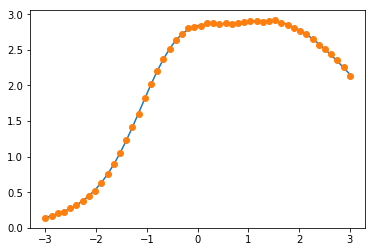

In [104]:
n = 50
x = np.linspace(-3, 3, n)

# Combination of three Gauss functions
y = 1.*np.exp(-((x + 0.5) / 1)**2) +  1.*np.exp(-((x - 1.0) / 2)**2) + 1.0*2.*np.exp(-((x - 2.0) / 3)**2)
y_true = y + 0.01*np.random.normal(0, 1, n)

plt.plot(x, y, '-');
plt.plot(x, y_true, 'o');

#### Разложение аппроксимирующей функции по радиальным базисным функциям

$y=\sum\limits_{i=1}^m{a_i\varphi_i(x)}\hspace{10mm}\varphi_i=\mathrm{e}^{-\left(\dfrac{x-b_i}{d_i}\right)^2}$
  
Представим параметры $a, b, d$ в виде одного вектора $w$ как их последовательную конкатенацию
  
$y=\sum\limits_{i=1}^m{w_i\varphi_i(x)}\hspace{10mm}\varphi_i=\mathrm{e}^{-\left(\dfrac{x-w_{i+m}}{w_{i+2m}}\right)^2}$

In [105]:
def basis_functions(w, x):
    basis = np.ndarray((len(x), m))
    for i in range(len(x)):
        basis[i] = np.exp(-((x[i] - w[m:m*2]) / w[m*2:m*3])**2)
    return np.sum(basis*w[:m], axis=1)

#### Производные аппроксимирующей функции по параметрам

$\dfrac{\partial y}{\partial a_i}=\mathrm{e}^{-\left(\frac{x-b_i}{d_i}\right)^2}$
  
$\dfrac{\partial y}{\partial b_i}=\dfrac{2a_i\left(x-b_i\right)\mathrm{e}^{-\left(\frac{x-b_i}{d_i}\right)^2}}{d_i^2}$
  
$\dfrac{\partial y}{\partial d_i}=\dfrac{2a_i\left(x-b_i\right)^2\mathrm{e}^{-\left(\frac{x-b_i}{d_i}\right)^2}}{d_i^3}$

In [106]:
def basis_functions_deriv(w, x):
    deriv = np.zeros((3*m, len(x)))
    for i in range(3*m):
        if i < m: # a
            deriv[i] = np.exp(-((x - w[m+i]) / w[m*2+i])**2)
        elif i < 2*m: # b
            expon = np.exp(-((x - w[i]) / w[m+i])**2)
            deriv[i] = (2*w[i-m]*(x-w[i])*expon)/(w[i+m]**2)
        elif i < 3*m: # d
            expon = np.exp(-((x - w[i-m]) / w[i])**2)
            deriv[i] =(2*w[i-2*m]*((x-w[i-m])**2)*expon)/(w[i]**3)
    
    return deriv

#### Вторые производные аппроксимирующей функции по параметрам

$\dfrac{\partial^2 y}{\partial a_i \partial a_j}=0\hspace{10mm}\forall{i,j}$
  
$\dfrac{\partial^2 y}{\partial a_i \partial b_j}=\dfrac{2\left(x-b_i\right)\mathrm{e}^{-\left(\frac{x-b_i}{d_i}\right)^2}}{d_i^2}\hspace{10mm}i=j$
  
$\dfrac{\partial^2 y}{\partial a_i \partial d_j}=\dfrac{2\left(x-b_i\right)^2\mathrm{e}^{-\left(\frac{x-b_i}{d_i}\right)^2}}{d_i^3}\hspace{10mm}i=j$
  
---------
$\dfrac{\partial^2 y}{\partial b_i \partial a_j}=\dfrac{2\left(x-b_i\right)\mathrm{e}^{-\left(\frac{x-b_i}{d_i}\right)^2}}{d_i^2}\hspace{10mm}i=j$
  
$\dfrac{\partial^2 y}{\partial b_i \partial b_j}=\dfrac{2a_i\left(2x^2-4xb_i+2x^2-d_i^2\right)\mathrm{e}^{-\left(\frac{x-b_i}{d_i}\right)^2}}{d_i^4}\hspace{10mm}i=j$
  
$\dfrac{\partial^2 y}{\partial b_i \partial d_j}=\dfrac{4a_i\left(b_i-x\right)\left(d_i^2-b_i^2+2xb_i-x^2\right)\mathrm{e}^{-\left(\frac{x-b_i}{d_i}\right)^2}}{d_i^5}\hspace{10mm}i=j$
  
---------
$\dfrac{\partial^2 y}{\partial d_i \partial a_j}=\dfrac{2\left(x-b_i\right)^2\mathrm{e}^{-\left(\frac{x-b_i}{d_i}\right)^2}}{d_i^3}\hspace{10mm}i=j$
  
$\dfrac{\partial^2 y}{\partial d_i \partial b_j}=\dfrac{4a_i\left(b_i-x\right)\left(d_i^2-b_i^2+2xb_i-x^2\right)\mathrm{e}^{-\left(\frac{x-b_i}{d_i}\right)^2}}{d_i^5}\hspace{10mm}i=j$
  
$\dfrac{\partial^2 y}{\partial d_i \partial d_j}=-\dfrac{2a_i\left(x-b_i\right)^2\left(3d_i^2-2b_i^2+4xb_i-2x^2\right)\mathrm{e}^{-\left(\frac{x-b_i}{d_i}\right)^2}}{d_i^6}\hspace{10mm}i=j$

In [107]:
def basis_functions_hess(w, x):
    hess = np.zeros((3*m, 3*m, len(x)))
    for i in range(3*m):
        if i < m: # a
            a = w[i]
            b = w[i+m]
            d = w[i+2*m]
            expon = np.exp(-((x - b) / d)**2)
            hess[i, i+m] = (2*(x-b)*expon)/(d**2)
            hess[i, i+2*m] = (2*((x-b)**2)*expon)/(d**3)
            
        elif i < 2*m: # b
            a = w[i-m]
            b = w[i]
            d = w[i+m]
            expon = np.exp(-((x - b) / d)**2)
            hess[i, i-m] = (2*(x-b)*expon)/(d**2)
            hess[i, i] = 2*a*(2*(b**2) - 4*x*b + 2*(x**2) - d**2)*expon/(d**4)
            hess[i, i+m] = -4*a*(b-x)*(b**2 - 2*x*b + x**2 - d**2)*expon/(d**5)
            
        elif i < 3*m: # d
            a = w[i-2*m]
            b = w[i-m]
            d = w[i]
            expon = np.exp(-((x - b) / d)**2)
            hess[i, i-2*m] = (2*((x-b)**2)*expon)/(d**3)
            hess[i, i-m] = -4*a*(x-b)*(d**2 - x**2 + 2*x*b - b**2)*expon/(d**5)
            hess[i, i] = -2*a*((x-b)**2)*(3*(d**2) - 2*(x**2) + 4*b*x - 2*(b**2))*expon/(d**6)
    
    return hess

#### Функция ошибки аппроксимации

$error = \sum\limits_{i=1}^n{\left(y_i-y_{true_i}\right)^2}$

In [108]:
def error_func(w):
    basis = basis_functions(w, x)
    error = 0
    for i in range(len(y_true)):
        error += (basis[i] - y_true[i])**2
    return error

#### Градиент целевой функции 

$\dfrac{\partial error}{\partial w_j} = 2\sum\limits_{i=1}^n{\dfrac{\partial y_i}{\partial w_j}\left(y_i-y_{true_i}\right)}$

In [109]:
def error_func_deriv(w):
    basis = basis_functions(w, x)
    basis_deriv = basis_functions_deriv(w, x)
    error_deriv = np.zeros(3*m)
    for i in range(3*m):
        error_deriv[i] = 2*np.sum((basis - y_true)*basis_deriv[i], axis=0)
    return error_deriv

#### Матрица Гессе целевой функции 

$\dfrac{\partial error}{\partial w_j \partial w_k} = 2\sum\limits_{i=1}^n{\left(\dfrac{\partial y_i}{\partial w_j}\dfrac{\partial y_i}{\partial w_k} + \dfrac{\partial^2 y_i}{\partial w_j \partial w_k}\left(y_i-y_{true_i}\right)\right)}$

In [110]:
def error_func_hess(w):
    basis = basis_functions(w, x)
    basis_deriv = basis_functions_deriv(w, x)
    basis_hess = basis_functions_hess(w, x)
    error_hess = np.zeros((3*m, 3*m))
    for i in range(3*m):
        for j in range(3*m):
            error_hess[i,j] = 2*np.sum((basis_deriv[i]*basis_deriv[j] + basis_hess[i,j]*(basis - y_true)), axis=0)
    return error_hess

#### Задание начального приближения

In [111]:
m = 3 # number of basis functions
a = np.random.normal(loc=0,scale=3,size=m)
a = [1.0, 1.0, 1.0]
b = np.random.normal(loc=0,scale=1,size=m)
b = [0., 1., 1.5]
d = np.random.normal(loc=0,scale=1,size=m)
d = [2, 2, 2]
w = np.concatenate((a,b,d))
np.set_printoptions(precision=3, suppress=True)
print('Начальные параметры')
for i in range(m):
    print('a:{:>8.3f}   b:{:>8.3f}   d:{:>8.3f}'.format(w[i], w[i+m], w[i+2*m]))

Начальные параметры
a:   1.000   b:   0.000   d:   2.000
a:   1.000   b:   1.000   d:   2.000
a:   1.000   b:   1.500   d:   2.000


Начальная ошибка: 13.990658731298087


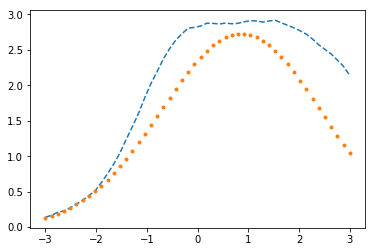

In [112]:
plt.plot(x, y_true, '--')
plt.plot(x, basis_functions(w, x), '.');
print('Начальная ошибка:', error_func(w))

#### Минимизация методом 0-го порядка

Optimization terminated successfully.
         Current function value: 0.054913
         Iterations: 1919
         Function evaluations: 2729

Параметры аппроксимирующей функции после оптимизации
a:   2.764   b:   0.000   d:   1.592
a:   2.129   b:   2.002   d:   1.154
a:   1.052   b:   3.083   d:   0.683
Ошибка после минимизации: 0.054912919927395776
Wall time: 1.72 s


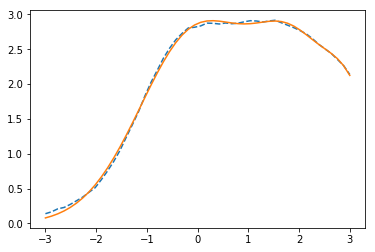

In [113]:
%%time
res = minimize(error_func, w, method='Nelder-Mead',options={'maxiter':10000,'disp': True})
print('\nПараметры аппроксимирующей функции после оптимизации')
for i in range(m):
    print('a:{:>8.3f}   b:{:>8.3f}   d:{:>8.3f}'.format(res.x[i], res.x[i+m], res.x[i+2*m]))
print('Ошибка после минимизации:', res.fun)
plt.plot(x, y_true, '--')
#plt.plot(x, basis_functions(w, x), '.')
plt.plot(x, basis_functions(res.x, x));

#### Минимизация методом 1-го порядка

Optimization terminated successfully.
         Current function value: 0.004256
         Iterations: 152
         Function evaluations: 175
         Gradient evaluations: 175

Параметры аппроксимирующей функции после оптимизации
a:   1.040   b:  -0.508   d:   0.998
a:   0.281   b:   0.742   d:   1.364
a:   2.687   b:   1.695   d:   2.731
Ошибка после минимизации: 0.004255611295163136
Wall time: 290 ms


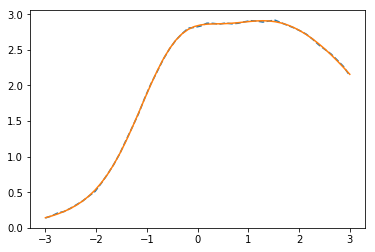

In [114]:
%%time
res = minimize(error_func, w, method='BFGS', jac=error_func_deriv, options={'maxiter':10000, 'disp': True})
#res = minimize(error_func, w, method='BFGS', options={'maxiter':10000, 'disp': True})
print('\nПараметры аппроксимирующей функции после оптимизации')
for i in range(m):
    print('a:{:>8.3f}   b:{:>8.3f}   d:{:>8.3f}'.format(res.x[i], res.x[i+m], res.x[i+2*m]))
print('Ошибка после минимизации:', res.fun)
plt.plot(x, y_true, '--')
#plt.plot(x, basis_functions(w, x), '.')
plt.plot(x, basis_functions(res.x, x));

#### Минимизация методом 2-го порядка

Optimization terminated successfully.
         Current function value: 0.004256
         Iterations: 224
         Function evaluations: 259
         Gradient evaluations: 482
         Hessian evaluations: 224

Параметры аппроксимирующей функции после оптимизации
a:   1.039   b:  -0.508   d:   0.998
a:   0.283   b:   0.740   d:   1.369
a:   2.685   b:   1.695   d:   2.732
Ошибка после минимизации: 0.0042556260704781825
Wall time: 1.19 s


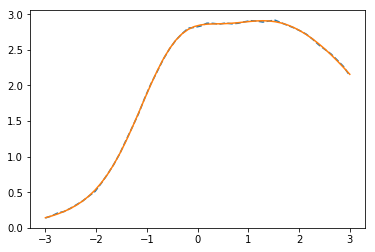

In [115]:
%%time
res = minimize(error_func, w, method='Newton-CG', jac=error_func_deriv, hess=error_func_hess, options={'maxiter':10000, 'disp': True})
print('\nПараметры аппроксимирующей функции после оптимизации')
for i in range(m):
    print('a:{:>8.3f}   b:{:>8.3f}   d:{:>8.3f}'.format(res.x[i], res.x[i+m], res.x[i+2*m]))
print('Ошибка после минимизации:', res.fun)
plt.plot(x, y_true, '--')
#plt.plot(x, basis_functions(w, x), '.')
plt.plot(x, basis_functions(res.x, x));

#### Минимизация с ограничениями

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00495653540318902
            Iterations: 37
            Function evaluations: 419
            Gradient evaluations: 37

Параметры аппроксимирующей функции после оптимизации
a:   0.932   b:  -0.496   d:   0.977
a:   1.677   b:   0.991   d:   2.294
a:   1.427   b:   2.454   d:   3.000
Wall time: 279 ms


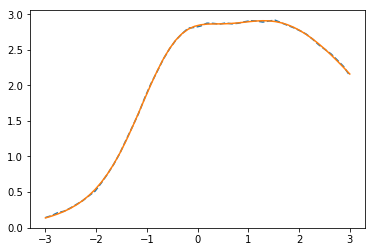

In [116]:
%%time
b1 = (0.0,2.0)
b2 = (-3,3)
b3 = (0.0,3.0)
bnds = (b1, b1, b1, b2, b2, b2, b3, b3, b3)
res = minimize(error_func,w,method='SLSQP',\
                    bounds=bnds, options={'maxiter':10000, 'disp': True})

print('\nПараметры аппроксимирующей функции после оптимизации')
for i in range(m):
    print('a:{:>8.3f}   b:{:>8.3f}   d:{:>8.3f}'.format(res.x[i], res.x[i+m], res.x[i+2*m]))
plt.plot(x, y_true, '--')
plt.plot(x, basis_functions(res.x, x))